In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, identity
import cv2
from IPython.display import clear_output
import time
from matplotlib import animation


def box_house(posx, posy, x, y):
    return (posx < x < posx + 18 and posy < y < posy + 18)


def l_house(posx, posy, x, y):
    return (posx < x < posx + 18 and posy < y < posy + 78) or (posx < x + 12 < posx + 13 and posy < y - 60 < posy + 18)


def L_house(posx, posy, x, y):
    return (posx < x < posx + 18 and posy < y < posy + 78) or (posx < x - 17 < posx + 12 and posy < y < posy + 18)


def check_boxes(x, y):
    boxes = [(69, 111), (69, 264),
             (138, 12), (138, 165),
             (192, 111), (192, 264),
             (261, 12), (261, 165)]
    for box in boxes:
        if box_house(box[0], box[1], x, y):
            return True
    return False


def check_l(x, y):
    l_houses = [(138, 51), (138, 204),
                (261, 51), (261, 204)]
    for house in l_houses:
        if l_house(house[0], house[1], x, y):
            return True
    return False


def check_L(x, y):
    L_houses = [(69, 12), (69, 165),
                (192, 12), (192, 165)]
    for house in L_houses:
        if L_house(house[0], house[1], x, y):
            return True
    return False


def check_houses(x, y):
    return check_boxes(x, y) or check_l(x, y) or check_L(x, y)


def check_edge_cond(x, y, n):
    x = (x/n)*300
    y = (y/n)*300
    return check_houses(x, y) or (x > 299 or y > 299 or y == 0 or x < 0)


def crossSchema(eps=0.5e-5, history=True):
    n = 300
    k = 0.5
    lambda1 = 1.0
    lambda2 = 0.0
    steps = 300000
    pictures = 3000

    N = n ** 2
    h = 1 / n
    tau = h ** 2 / (4 * k)

    x = np.zeros((N, 1))
    for i in range(n):
        x[i:n, 0] = 1

    A = lil_matrix((N, N))
    b = np.zeros(N)

    dx = [1, -1, 0, 0]
    dy = [0, 0, 1, -1]
    u0coeff = 1 - 4 * (tau * k) / (h ** 2)
    coeffs = [tau * (k / (h ** 2) - lambda1 / (2 * h)),
              tau * (k / (h ** 2) + lambda1 / (2 * h)),
              tau * (k / (h ** 2) - lambda2 / (2 * h)),
              tau * (k / (h ** 2) + lambda2 / (2 * h))]

    for i in range(n):
        for e in range(n):
            ind = i * n + e
            A[ind, ind] = u0coeff
            if (check_edge_cond(i, e, n)):
                continue

            for j in range(0, 4):
                x1 = i + dx[j]
                y1 = e + dy[j]
                coeff = coeffs[j]

                if x1==0:
                    b[ind] -= coeff
                elif check_edge_cond(x1, y1, n):
                    A[ind, ind] += coeff
                else:
                    A[ind, x1 * n + y1] += coeff

    A = csr_matrix(A)
    b = b.reshape(N, -1)
    pic = []
    error = 1
    i = 0
    for i in range(steps):
        x_new = A * x + b
        error = np.max(np.abs(x_new - x))
        if error < eps:
            break
        x = x_new
        if history:
            if i % (steps // pictures) == 0:
                clear_output()
                print(f'Step #{i//(steps//pictures)} out of {pictures}. Error is {error}')
                pic.append(-x.reshape((n, n)).T)
        i += 1
        
    return -x.reshape((n, n)).T, pic, error


Step #1120 out of 3000. Error is 5.002274194032541e-06
Final Error is 4.999971642438705e-06. Computational time - 107.44898796081543


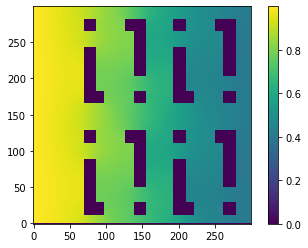

In [2]:
start = time.time()
x_res, steps, error = crossSchema()
end = time.time()
print(f'Final Error is {error}. Computational time - {end - start}')
fig = plt.imshow(x_res)
plt.colorbar(fig)
plt.gca().invert_yaxis()
plt.show()

In [3]:
out = cv2.VideoWriter('diff.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 60, (300,300))
out_shorter = cv2.VideoWriter('diff short.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 60, (300,300))
i = 0
for step in steps:
    s = step[::-1, :]/np.max(step)*255
    s = np.array(s, dtype=np.uint8)
    s = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    s = cv2.resize(s, (300, 300))
    out.write(s)
    i+=1
    if i < 1000:
        out_shorter.write(s)
out.release()
out_shorter.release()

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


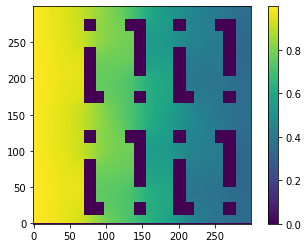

In [5]:
fig = plt.figure()
ims = []

i = 0
for step in steps:
    im = plt.imshow(step, animated=True)
    ims.append([im])
    i+=1
    if i > 1000:
        break
plt.gca().invert_yaxis()
plt.colorbar(im)

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('diffuzia 2.gif')

plt.show()